In [1]:
from imag import *

In [2]:
# @title Test code space
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from networkx.algorithms.approximation import max_clique

## Ising model test

In [3]:
# @title Ising model
n = 4

coeffs_Z = -0.5*np.ones(4)
coeffs_X = -0.1*np.ones(4)
coeffs = np.concatenate([coeffs_Z, coeffs_X])

print(coeffs)
ops = [
    qml.PauliZ(0) @ qml.PauliZ(1),
    qml.PauliZ(1) @ qml.PauliZ(2),
    qml.PauliZ(2) @ qml.PauliZ(3),
    qml.PauliZ(0) @ qml.PauliZ(3),
    qml.PauliX(0),
    qml.PauliX(1),
    qml.PauliX(2),
    qml.PauliX(3)
    ]

H_ising = qml.Hamiltonian(coeffs, ops)
H_ising = np.matrix(qml.matrix(H_ising))
#print(H_ising)
#H = #np.array(...) 2D matrix
hamiltonian = Hamiltonian(H_ising, commute_map=True)

[-0.5 -0.5 -0.5 -0.5 -0.1 -0.1 -0.1 -0.1]


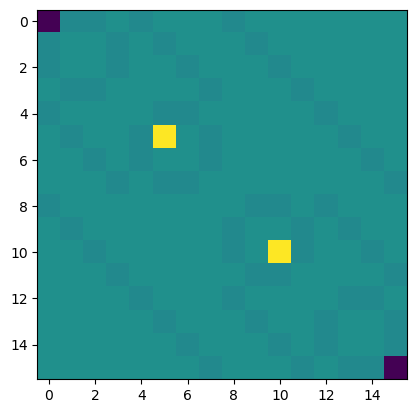

In [4]:
plt.imshow(H_ising.real)

In [5]:
G_b = get_binary_graph(hamiltonian) # get commuting graph
g_classic = deepcopy(G_b)
max_cliques = []
while len(g_classic.nodes) >0:
    clique = max_clique(g_classic)
    max_cliques.append(clique)
    for node in clique:
        g_classic.remove_node(node)
print(max_cliques)

[{'IZZI', 'IIZZ', 'ZIIZ', 'ZZII'}, {'IIXI', 'IIIX', 'XIII', 'IXII'}]


In [14]:
N = hamiltonian.qubit_num # number of qubits
dev = qml.device('default.qubit', wires=N+1, shots=1000)

In [15]:
hamiltonian.local_decomposition["Pstring"]


0    IIZZ
1    IZZI
2    ZIIZ
3    ZZII
4    IIIX
5    IIXI
6    IXII
7    XIII
Name: Pstring, dtype: object

In [16]:
#@qml.defer_measurements
@qml.qnode(dev)
def evolve_hamiltonian(h:Hamiltonian, max_cliques:list, t:float, iter:int, N:int):
    for i in range(N-1):
        qml.Hadamard(i)
    print(f"Evolve time:{t*iter}")
    print(f"Trotter-Level:{iter}")
    print(f"Wires:{N}")
    if np.fabs(t)<1E-8:
        hermit = qml.Hermitian(h.Hamiltonian, wires=range(h.qubit_num))
        return qml.expval(hermit)

    qml.Barrier(wires=range(N))
    # coef 
    gamma = coef_scale = np.abs(h.local_decomposition.iloc[:, 4]).max()
     
    for k in range(iter):
        #print(f"{k+1}/{iter}", end="\t")
        i=0
        l = len(max_cliques)
        for i, c in enumerate(max_cliques):
            for j, p in enumerate(c):
                coef_i = complex(h.local_decomposition.loc[h.local_decomposition["Pstring"] == p].iloc[0, 3])
                #print(coef)
                evolve_circuit(
                    p,
                    0,
                    coef_i,
                    t,
                    True, #imaginary,
                    gamma
                )
                qml.Barrier(wires=range(h.qubit_num))
                i+=1
                # mid-measurement
                m0 = qml.measure(N-1, postselect=0)#-requires new wires for each mid-measurement.
                #print(m0)
                #qml.cond((m0 == 1), qml.Hadamard)(N+1)
                #m1 = (qml.measure(N +1))
                #qml.cond(m0 == 1 and m1 == 0, qml.PauliX)(N+1)
                #if m0 == 1:
                #    print("Failed")
                #    break
                #
            #if m0==1:
            #    break
    hermit = qml.Hermitian(h.Hamiltonian, wires=range(h.qubit_num))
    return qml.expval(hermit)

Evolve time:0.1
Trotter-Level:1
Wires:5


/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_54987/1822880935.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


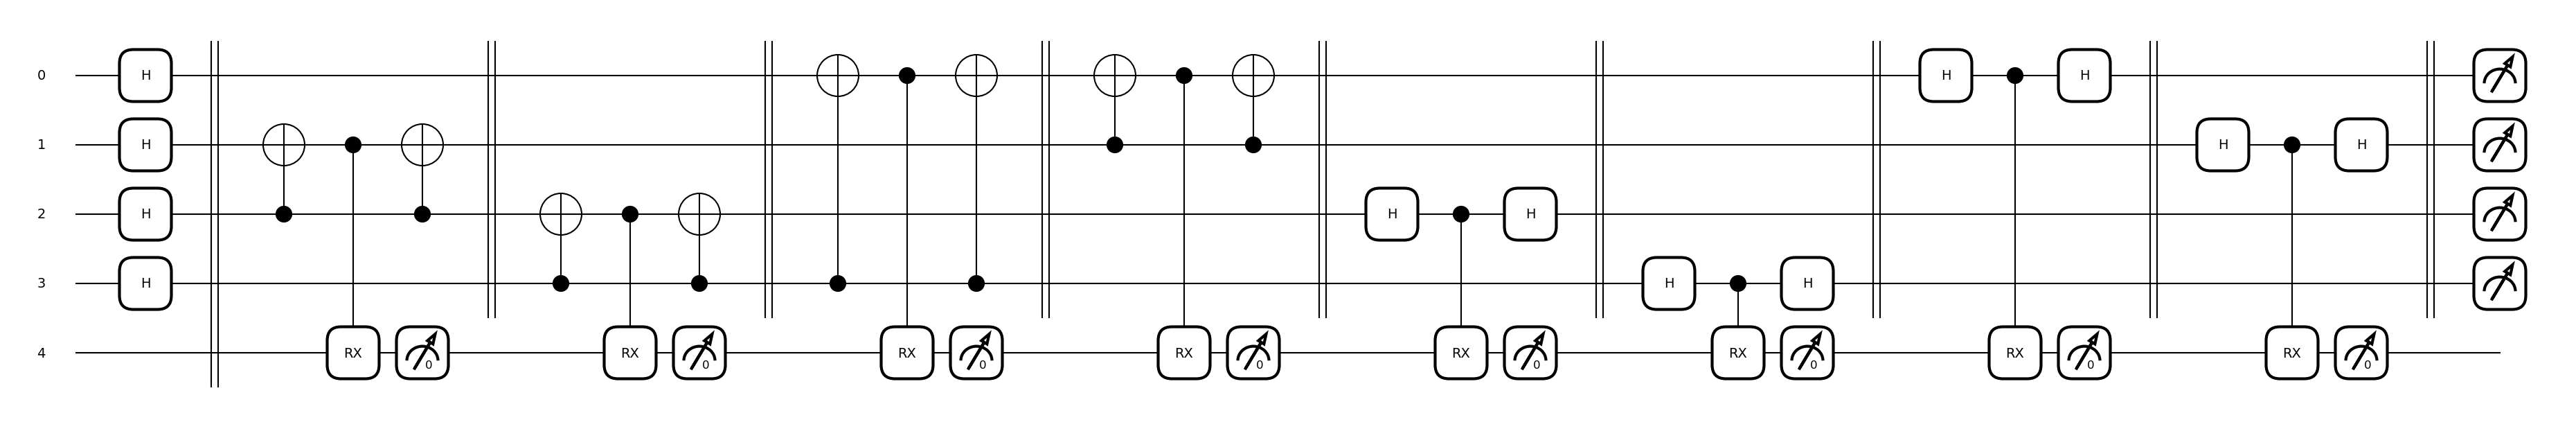

In [9]:
t=0.1
fig, ax = qml.draw_mpl(evolve_hamiltonian)(hamiltonian, max_cliques, t, 1,N+1)
fig.show()

In [10]:
evolve_hamiltonian(hamiltonian, max_cliques, 0.1, 2, N+1) # t = 0.2, (sec)

Evolve time:0.2
Trotter-Level:2
Wires:5


-0.6714060519375176

In [22]:
# Paper figure
trotter_step = 5
energies = []
dt = 0.1
print(dt)
for i in range(0, 10):
    print(f"Configuration:t={dt}, T_level:{trotter_step}")
    e = evolve_hamiltonian(hamiltonian, max_cliques, dt, i*trotter_step, N+1) #
    print(f"E:{e}")
    energies.append(e)


0.1
Configuration:t=0.1, T_level:5
Evolve time:0.0
Trotter-Level:0
Wires:5
E:-0.3985904866030855
Configuration:t=0.1, T_level:5
Evolve time:0.5
Trotter-Level:5
Wires:5
E:-0.9581434920180111
Configuration:t=0.1, T_level:5
Evolve time:1.0
Trotter-Level:10
Wires:5
E:-1.3597216494519153
Configuration:t=0.1, T_level:5
Evolve time:1.5
Trotter-Level:15
Wires:5
E:-1.771683177079005
Configuration:t=0.1, T_level:5
Evolve time:2.0
Trotter-Level:20
Wires:5
E:-2.020296849601932
Configuration:t=0.1, T_level:5
Evolve time:2.5
Trotter-Level:25
Wires:5


In [18]:
print(energies)

[-0.42083519508682443, -1.280671173846224, -0.280001141941442, -2.020296849601932]


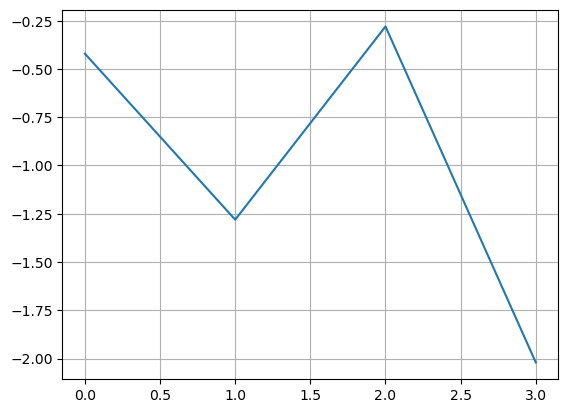

In [21]:
plt.plot(range(0, 4), energies)
plt.grid()